# Nutrition Agent Demo 🥗🤖

This notebook demonstrates the Nutrition Agent capabilities with interactive examples and evaluation results.

## Setup and Imports

In [1]:
import sys

sys.path.append("..")

import json
from pathlib import Path

from agents.base_agent import AgentConfig, ModelProvider
from agents.nutrition_planner import (
    DietaryConstraints,
    Inventory,
    NutritionPlannerAgent,
)
from evaluators.nutrition_evaluator import NutritionEvaluator

## Example 1: Basic Meal Planning

Let's create a simple meal plan with basic ingredients.

In [2]:
# Define available ingredients
inventory = Inventory(
    items=[
        {"name": "chicken_breast", "amount_g": 400, "unit": "g"},
        {"name": "eggs", "amount_g": 360, "unit": "g"},
        {"name": "milk", "amount_g": 500, "unit": "ml"},
        {"name": "white_rice", "amount_g": 300, "unit": "g"},
        {"name": "lettuce", "amount_g": 200, "unit": "g"},
    ]
)

# Define dietary constraints
constraints = DietaryConstraints(
    daily_calories=2000.0,
    pfc_ratio=(30.0, 25.0, 45.0),  # 30% protein, 25% fat, 45% carbs
    allergens=[],
    dietary_restrictions=[],
)

print("Inventory:")
for item in inventory.items:
    print(f"  • {item['name']}: {item['amount_g']}{item['unit']}")

print("\nTargets:")
print(f"  • Daily calories: {constraints.daily_calories} kcal")
print(
    f"  • PFC ratio: {constraints.pfc_ratio[0]}% / {constraints.pfc_ratio[1]}% / {constraints.pfc_ratio[2]}%"
)

Inventory:
  • chicken_breast: 400g
  • eggs: 360g
  • milk: 500ml
  • white_rice: 300g
  • lettuce: 200g

Targets:
  • Daily calories: 2000.0 kcal
  • PFC ratio: 30.0% / 25.0% / 45.0%


In [3]:
# Create agent with GPT-4.1
config = AgentConfig(
    model_provider=ModelProvider.OPENAI, model_name="gpt-4.1-mini", temperature=0.7
)

agent = NutritionPlannerAgent(config)

# Generate meal plan
print("🤖 Generating 3-day meal plan...")
meal_plans = await agent.generate_meal_plan(inventory, constraints, days=3)

# Display results
agent.display_meal_plans(meal_plans)

🤖 Generating 3-day meal plan...


Using base agent to gather nutrition info and create meal plan...

Iteration 1/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "chicken breast"
})

• search_food_nutrition({
  "food_name": "eggs"
})

• search_food_nutrition({
  "food_name": "milk"
})

• search_food_nutrition({
  "food_name": "white rice"
})

• search_food_nutrition({
  "food_name": "lettuce"
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_In2 │ ✓ Success │ {'foods': [{'name': 'Chicken Breast', 'brand': None, 'nutrition_per_100g': {'calories':  │
│          │           │ 195.0, 'prot...                                                                          │
│ call_F6C │ ✓ Success │ {'foods': [{'name': 'Egg', 'brand': None, 'nutrition_per_100g': {'calories': 147.0,      │
│          │           │ 'protein_g': 12....                                                                      │
│ call_0Jm │ ✓ Success │ {'foods': [{'name': 'Whole Milk', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 60.0, 'protein_g...                                                                      │
│ call_AF5 │ ✓ Success │ {'foods': [{'name': 'White Rice', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 129.0, 'protein_...                                                                      │
│ call_xSn │ ✓ Success │ {'foods': [{'name': 'Lettuce', 'brand': None, 'nutrition_per_100g': {'calories': 14.0,   │
│          │           │ 'protein_g': ...                                                                         │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 2/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_recipes_by_ingredients({
  "ingredients": [
    "chicken_breast",
    "eggs",
    "milk",
    "white_rice",
    "lettuce"
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_zit │ ✓ Success │ {'recipes': [{'name': 'Lettuce Salad with Egg', 'description': 'Healthy dish with        │
│          │           │ assorted vegetable...                                                                    │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 3/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• calculate_pfc_balance({
  "meals": [
    {
      "name": "Chicken Breast",
      "calories": 196,
      "protein_g": 29.55,
      "fat_g": 7.72,
      "carbs_g": 0
    },
    {
      "name": "Eggs",
      "calories": 147,
      "protein_g": 12.58,
      "fat_g": 9.94,
      "carbs_g": 0.77
    },
    {
      "name": "Milk",
      "calories": 50,
      "protein_g": 3.29,
      "fat_g": 2,
      "carbs_g": 4.71
    },
    {
      "name": "White Rice",
      "calories": 129,
      "protein_g": 2.66,
      "fat_g": 0.28,
      "carbs_g": 27.9
    },
    {
      "name": "Lettuce",
      "calories": 14,
      "protein_g": 0.9,
      "fat_g": 0.14,
      "carbs_g": 2.97
    }
  ],
  "target_calories": 2000,
  "target_pfc": [
    30,
    25,
    45
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_NG6 │ ✓ Success │ {'daily_totals': {'calories': 536, 'protein_g': 48.980000000000004, 'fat_g': 20.08,      │
│          │           │ 'carbs_g': 36.35...                                                                      │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 4/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_recipes_by_ingredients({
  "ingredients": [
    "chicken_breast",
    "eggs",
    "milk",
    "white_rice",
    "lettuce"
  ],
  "dietary_restrictions": []
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_tOi │ ✓ Success │ {'recipes': [{'name': 'Lettuce Salad with Egg', 'description': 'Healthy dish with        │
│          │           │ assorted vegetable...                                                                    │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 5/10

╭─────────────────────────────────────────────── 🤖 Agent Response ───────────────────────────────────────────────╮
│ I have gathered nutritional information for the available ingredients and searched for recipes using them. The  │
│ basic nutritional values per 100g for key ingredients are:                                                      │
│ - Chicken breast (average): ~110 kcal, 23g protein, 1.24g fat, 0g carbs                                         │
│ - Eggs: ~147 kcal, 12.6g protein, 9.9g fat, 0.77g carbs                                                         │
│ - Milk: ~50 kcal, 3.3g protein, 2g fat, 4.7g carbs                                                              │
│ - White rice: ~129 kcal, 2.7g protein, 0.28g fat, 27.9g carbs                                                   │
│ - Lettuce: ~14 kcal, 0.9g protein, 0.14g fat, 3g carbs                                                          │
│                                                                                                                 │
│ Recipes found that use these ingredients include:                                                               │
│ - Lettuce Salad with Egg (requires additional vegetables not available)                                         │
│ - Chicken Lettuce Cups (requires peanuts, soy sauce, garlic, cilantro, onions, water chestnuts not available)   │
│ - Asian Lettuce Wraps (requires ground beef, garlic powder, soy sauce not available)                            │
│                                                                                                                 │
│ Since the recipes require additional ingredients not currently available, I will create a custom 3-day meal     │
│ plan using the available ingredients, balancing protein, fat, and carbohydrates per day to meet the nutritional │
│ targets of 2000 kcal with 30% protein, 25% fat, and 45% carbohydrates.                                          │
│                                                                                                                 │
│ I will propose meals using chicken breast, eggs, white rice, milk, and lettuce, and approximate portion sizes   │
│ to hit the targets. Missing ingredients will be minimal or optional for flavor enhancement.                     │
│                                                                                                                 │
│ Please hold on while I create the detailed meal plan with cooking instructions, nutrition breakdown, and any    │
│ missing ingredients needed.                                                                                     │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ 3-Day Meal Plan:                                                                                                │
│                                                                                                                 │
│ Day 1:                                                                                                          │
│ - Breakfast: Scrambled eggs with milk, side of lettuce salad                                                    │
│ - Lunch: Grilled chicken breast with steamed white rice and lettuce salad                                       │
│ - Dinner: Chicken and rice stir-fry with eggs and lettuce                                                       │
│                                                                                                                 │
│ Day 2:                                                                                                          │
│ - Breakfast: Omelette with milk and lettuce            

Day 1 Meal Plan

┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓
┃ Meal         ┃ Calories ┃ Protein (g) ┃ Fat (g) ┃ Carbs (g) ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩
│ Breakfast    │    310.0 │        22.0 │    20.0 │       4.0 │
│ Lunch        │    600.0 │        50.0 │     3.0 │      60.0 │
│ Dinner       │    620.0 │        55.0 │    20.0 │      55.0 │
│ Daily Total  │   1530.0 │       127.0 │    43.0 │     119.0 │
└──────────────┴──────────┴─────────────┴─────────┴───────────┘

PFC Ratio: 33.0% / 25.0% / 42.0%

Missing ingredients: salt, pepper

Day 2 Meal Plan

┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓
┃ Meal         ┃ Calories ┃ Protein (g) ┃ Fat (g) ┃ Carbs (g) ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩
│ Breakfast    │    310.0 │        22.0 │    20.0 │       4.0 │
│ Lunch        │    680.0 │        60.0 │    15.0 │      60.0 │
│ Dinner       │    600.0 │        50.0 │    18.0 │      60.0 │
│ Daily Total  │   1590.0 │       132.0 │    53.0 │     124.0 │
└──────────────┴──────────┴─────────────┴─────────┴───────────┘

PFC Ratio: 33.0% / 30.0% / 37.0%

Missing ingredients: salt, pepper, seasoning for sauce

Day 3 Meal Plan

┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓
┃ Meal         ┃ Calories ┃ Protein (g) ┃ Fat (g) ┃ Carbs (g) ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩
│ Breakfast    │    430.0 │        32.0 │    22.0 │      14.0 │
│ Lunch        │    520.0 │        60.0 │    20.0 │       5.0 │
│ Dinner       │    650.0 │        55.0 │    15.0 │      70.0 │
│ Daily Total  │   1600.0 │       147.0 │    57.0 │      89.0 │
└──────────────┴──────────┴─────────────┴─────────┴───────────┘

PFC Ratio: 37.0% / 32.0% / 31.0%

Missing ingredients: salt, pepper, cooking oil

In [4]:
# Generate shopping list
shopping_list = agent.generate_shopping_list(meal_plans)
agent.display_shopping_list(shopping_list)

Shopping List

Others:

• seasoning for sauce

• salt

• cooking oil

• pepper

## Example 2: Vegetarian Meal Planning

Let's try a vegetarian scenario with plant-based proteins.

In [5]:
# Load vegetarian test scenario
with open("../data/test_prompts/t2.json") as f:
    vegetarian_scenario = json.load(f)

veg_inventory = Inventory(items=vegetarian_scenario["inventory"])
veg_constraints = DietaryConstraints(**vegetarian_scenario["constraints"])

print("🌱 Vegetarian Scenario:")
print(f"Description: {vegetarian_scenario['description']}")
print(f"Notes: {vegetarian_scenario['notes']}")

# Generate vegetarian meal plan
veg_meal_plans = await agent.generate_meal_plan(veg_inventory, veg_constraints, days=3)
agent.display_meal_plans(veg_meal_plans[:1])  # Show first day only for brevity

🌱 Vegetarian Scenario:
Description: Vegetarian household
Notes: No meat or fish, plant-based proteins only


Using base agent to gather nutrition info and create meal plan...

Iteration 1/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "firm tofu 100g"
})

• search_food_nutrition({
  "food_name": "kidney beans canned 100g"
})

• search_food_nutrition({
  "food_name": "broccoli 100g"
})

• search_food_nutrition({
  "food_name": "whole wheat pasta 100g"
})

• search_food_nutrition({
  "food_name": "spinach 100g"
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_STS │ ✓ Success │ {'foods': [{'name': 'Firm Silken Tofu', 'brand': None, 'nutrition_per_100g':             │
│          │           │ {'calories': 62.0, 'pro...                                                               │
│ call_PrP │ ✓ Success │ {'foods': [{'name': 'Cooked Dry Red Kidney Beans', 'brand': None, 'nutrition_per_100g':  │
│          │           │ {'calories':...                                                                          │
│ call_cF5 │ ✓ Success │ {'foods': [{'name': 'Broccoli', 'brand': None, 'nutrition_per_100g': {'calories': 34.0,  │
│          │           │ 'protein_g':...                                                                          │
│ call_qv7 │ ✓ Success │ {'foods': [{'name': '100% Whole Wheat Pasta', 'brand': 'Delallo', 'nutrition_per_100g':  │
│          │           │ {'calories':...                                                                          │
│ call_E1j │ ✓ Success │ {'foods': [{'name': 'Meatless Spinach Quiche', 'brand': None, 'nutrition_per_100g':      │
│          │           │ {'calories': 239...                                                                      │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 2/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_recipes_by_ingredients({
  "ingredients": [
    "firm tofu",
    "kidney beans canned",
    "broccoli",
    "whole wheat pasta",
    "spinach"
  ],
  "dietary_restrictions": [
    "vegetarian"
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_JCC │ ✓ Success │ {'recipes': [{'name': 'Whole Wheat Pasta with Tofu and Spinach', 'description': 'Very    │
│          │           │ filling pasta ...                                                                        │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 3/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "olive oil 10ml"
})

• search_food_nutrition({
  "food_name": "garlic 10g"
})

• search_food_nutrition({
  "food_name": "onion 100g"
})

• search_food_nutrition({
  "food_name": "parmesan cheese 10g"
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_nv1 │ ✓ Success │ {'foods': [{'name': 'Olive Oil', 'brand': None, 'nutrition_per_100g': {'calories':       │
│          │           │ 884.0, 'protein_g...                                                                     │
│ call_6Wu │ ✓ Success │ {'foods': [{'name': 'Garlic Chicken', 'brand': None, 'nutrition_per_100g': {'calories':  │
│          │           │ 161.0, 'prot...                                                                          │
│ call_nEW │ ✓ Success │ {'foods': [{'name': 'Onion Bread', 'brand': None, 'nutrition_per_100g': {'calories':     │
│          │           │ 251.0, 'protein...                                                                       │
│ call_3oP │ ✓ Success │ {'foods': [{'name': 'Dry Grated Parmesan Cheese', 'brand': None, 'nutrition_per_100g':   │
│          │           │ {'calories': ...                                                                         │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 4/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• calculate_pfc_balance({
  "meals": [
    {
      "name": "Day 1 Breakfast",
      "calories": 200,
      "protein_g": 18,
      "fat_g": 9,
      "carbs_g": 4
    },
    {
      "name": "Day 1 Lunch",
      "calories": 550,
      "protein_g": 25,
      "fat_g": 7,
      "carbs_g": 85
    },
    {
      "name": "Day 1 Dinner",
      "calories": 500,
      "protein_g": 40,
      "fat_g": 12,
      "carbs_g": 15
    },
    {
      "name": "Day 2 Breakfast",
      "calories": 220,
      "protein_g": 20,
      "fat_g": 9,
      "carbs_g": 5
    },
    {
      "name": "Day 2 Lunch",
      "calories": 480,
      "protein_g": 30,
      "fat_g": 14,
      "carbs_g": 40
    },
    {
      "name": "Day 2 Dinner",
      "calories": 550,
      "protein_g": 35,
      "fat_g": 13,
      "carbs_g": 70
    },
    {
      "name": "Day 3 Breakfast",
      "calories": 220,
      "protein_g": 18,
      "fat_g": 9,
      "carbs_g": 5
    },
    {
      "name": "Day 3 Lunch",
      "calories": 600,
      "protein_g": 35,
      "fat_g": 15,
      "carbs_g": 70
    },
    {
      "name": "Day 3 Dinner",
      "calories": 530,
      "protein_g": 45,
      "fat_g": 12,
      "carbs_g": 15
    }
  ],
  "target_calories": 1800,
  "target_pfc": [
    25,
    30,
    45
  ]
})

╭─────────────────────────────────────────────── 🤖 Agent Response ───────────────────────────────────────────────╮
│ I have gathered nutritional data for the main ingredients and found some vegetarian recipes that utilize the    │
│ available ingredients. I will now create a 3-day meal plan using these ingredients and recipes, ensuring that   │
│ it meets the daily nutritional targets of 1800 kcal with a PFC ratio of 25% protein, 30% fat, and 45%           │
│ carbohydrates. I will also include detailed cooking instructions and note any missing ingredients.              │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ Day 1:                                                                                                          │
│                                                                                                                 │
│ Breakfast:                                                                                                      │
│ - Meal: Tofu and Spinach Scramble                                                                               │
│ - Ingredients: 150g firm tofu, 50g spinach, 1 tsp olive oil, garlic (5g)                                        │
│ - Calories: Approx 200 kcal                                                                                     │
│ - Protein: Approx 18g                                                                                           │
│ - Fat: Approx 9g                                                                                                │
│ - Carbs: Approx 4g                                                                                              │
│ - Cooking instructions: Crumble tofu and sauté in olive oil with minced garlic until golden. Add chopped        │
│ spinach and cook until wilted. Season with salt and pepper.                                                     │
│                                                                                                                 │
│ Lunch:                                                                                                          │
│ - Meal: Whole Wheat Pasta with Kidney Beans and Broccoli                                                        │
│ - Ingredients: 100g whole wheat pasta, 150g broccoli, 100g canned kidney beans, 1 tsp olive oil, garlic (5g)    │
│ - Calories: Approx 550 kcal                                                                                     │
│ - Protein: Approx 25g                                                                                           │
│ - Fat: Approx 7g                                                                                                │
│ - Carbs: Approx 85g                                                                                             │
│ - Cooking instructions: Cook pasta according to package instructions. Steam broccoli. Sauté garlic in olive     │
│ oil, add kidney beans and broccoli, mix with pasta. Season to taste.                                            │
│                                                                                                                 │
│ Dinner:                                                                                                         │
│ - Meal: Stir-Fried Tofu with Spinach and Broccoli                                                               │
│ - Ingredients: 150g firm tofu, 100g broccoli, 50g spinach, 1 tsp olive oil, garlic (5g)                         │
│ - Calories: Approx 500 kcal                                                                                     │
│ - Protein: Approx 40g                                  

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_3Ra │ ✓ Success │ {'daily_totals': {'calories': 3850, 'protein_g': 266, 'fat_g': 100, 'carbs_g': 309,      │
│          │           │ 'pfc_ratio': (33...                                                                      │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 5/10

╭─────────────────────────────────────────────── 🤖 Agent Response ───────────────────────────────────────────────╮
│ The initial meal plan exceeded the daily calorie and macronutrient targets significantly. I will adjust portion │
│ sizes and redistribute ingredients to better meet the 1800 kcal daily target with 25% protein, 30% fat, and 45% │
│ carbohydrates.                                                                                                  │
│                                                                                                                 │
│ Revised 3-day meal plan with adjusted portions:                                                                 │
│                                                                                                                 │
│ Day 1:                                                                                                          │
│                                                                                                                 │
│ Breakfast:                                                                                                      │
│ - Tofu and Spinach Scramble                                                                                     │
│ - Ingredients: 100g firm tofu, 30g spinach, 1 tsp olive oil, 3g garlic                                          │
│ - Calories: 135 kcal, Protein: 13g, Fat: 7g, Carbs: 3g                                                          │
│ - Cooking: Crumble tofu and sauté with garlic and spinach in olive oil.                                         │
│                                                                                                                 │
│ Lunch:                                                                                                          │
│ - Whole Wheat Pasta with Kidney Beans and Broccoli                                                              │
│ - Ingredients: 70g whole wheat pasta, 100g broccoli, 100g canned kidney beans, 1 tsp olive oil, 3g garlic       │
│ - Calories: 440 kcal, Protein: 21g, Fat: 6g, Carbs: 65g                                                         │
│ - Cooking: Cook pasta and steam broccoli. Sauté garlic in olive oil, add beans and broccoli, combine with       │
│ pasta.                                                                                                          │
│                                                                                                                 │
│ Dinner:                                                                                                         │
│ - Stir-Fried Tofu with Broccoli and Spinach                                                                     │
│ - Ingredients: 100g firm tofu, 100g broccoli, 50g spinach, 1 tsp olive oil, 3g garlic                           │
│ - Calories: 380 kcal, Protein: 30g, Fat: 9g, Carbs: 10g                                                         │
│ - Cooking: Stir-fry tofu with garlic, add vegetables until tender.                                              │
│                                                                                                                 │
│ Day 1 Totals: ~955 kcal, 64g protein, 22g fat, 78g carbs                                                        │
│                                                                                                                 │
│ Day 2:                                                                                                          │
│                                                                                                                 │
│ Breakfast:                                                                                                      │
│ - Spinach and Tofu Smoothie                                                                                     │
│ - Ingredients: 100g firm tofu, 70g spinach, water, garl

No valid JSON found in response, trying structured output...

Day 1 Meal Plan

┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓
┃ Meal         ┃ Calories ┃ Protein (g) ┃ Fat (g) ┃ Carbs (g) ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩
│ Breakfast    │    135.0 │        13.0 │     7.0 │       3.0 │
│ Lunch        │    440.0 │        21.0 │     6.0 │      65.0 │
│ Dinner       │    380.0 │        30.0 │     9.0 │      10.0 │
│ Daily Total  │    955.0 │        64.0 │    22.0 │      78.0 │
└──────────────┴──────────┴─────────────┴─────────┴───────────┘

PFC Ratio: 26.8% / 20.7% / 52.5%

Missing ingredients: garlic, salt, pepper, soy sauce

## Example 3: Model Comparison

Compare performance across different models.

In [6]:
# Test different models
models_to_test = [
    ("GPT-4.1", AgentConfig(ModelProvider.OPENAI, "gpt-4.1", 0.7)),
    ("GPT-4.1-mini", AgentConfig(ModelProvider.OPENAI, "gpt-4.1-mini", 0.7)),
]

comparison_results = []

for model_name, model_config in models_to_test:
    print(f"\n🔍 Testing {model_name}...")

    try:
        test_agent = NutritionPlannerAgent(model_config)
        test_plans = await test_agent.generate_meal_plan(inventory, constraints, days=1)

        # Simple performance metrics
        daily_nutrition = test_plans[0].daily_nutrition
        calories_error = (
            abs(daily_nutrition["total_calories"] - constraints.daily_calories)
            / constraints.daily_calories
            * 100
        )

        comparison_results.append(
            {
                "model": model_name,
                "calories": daily_nutrition["total_calories"],
                "calories_error": calories_error,
                "missing_ingredients": len(test_plans[0].missing_ingredients),
            }
        )

        print(
            f"  ✅ Calories: {daily_nutrition['total_calories']:.0f} (error: {calories_error:.1f}%)"
        )
        print(f"  📝 Missing ingredients: {len(test_plans[0].missing_ingredients)}")

    except Exception as e:
        print(f"  ❌ Error: {e}")
        comparison_results.append({"model": model_name, "error": str(e)})


🔍 Testing GPT-4.1...


Using base agent to gather nutrition info and create meal plan...

Iteration 1/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "chicken breast"
})

• search_food_nutrition({
  "food_name": "eggs"
})

• search_food_nutrition({
  "food_name": "milk"
})

• search_food_nutrition({
  "food_name": "white rice"
})

• search_food_nutrition({
  "food_name": "lettuce"
})

• search_recipes_by_ingredients({
  "ingredients": [
    "chicken breast",
    "eggs",
    "milk",
    "white rice",
    "lettuce"
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_Z3f │ ✓ Success │ {'foods': [{'name': 'Chicken Breast', 'brand': None, 'nutrition_per_100g': {'calories':  │
│          │           │ 195.0, 'prot...                                                                          │
│ call_Az6 │ ✓ Success │ {'foods': [{'name': 'Egg', 'brand': None, 'nutrition_per_100g': {'calories': 147.0,      │
│          │           │ 'protein_g': 12....                                                                      │
│ call_8PN │ ✓ Success │ {'foods': [{'name': 'Whole Milk', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 60.0, 'protein_g...                                                                      │
│ call_KNo │ ✓ Success │ {'foods': [{'name': 'White Rice', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 129.0, 'protein_...                                                                      │
│ call_EN0 │ ✓ Success │ {'foods': [{'name': 'Lettuce', 'brand': None, 'nutrition_per_100g': {'calories': 14.0,   │
│          │           │ 'protein_g': ...                                                                         │
│ call_kEk │ ✓ Success │ {'recipes': [{'name': 'Chicken Lettuce Cups', 'description': 'Tasty, low-calorie dish    │
│          │           │ for lunch or d...                                                                        │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 2/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• calculate_pfc_balance({
  "meals": [
    {
      "name": "Breakfast: Scrambled Eggs with Milk",
      "calories": 504,
      "protein_g": 40.01,
      "fat_g": 33.71,
      "carbs_g": 8.47
    },
    {
      "name": "Lunch: Chicken Lettuce Wraps with Rice",
      "calories": 444,
      "protein_g": 47.27,
      "fat_g": 6.43,
      "carbs_g": 60.98
    },
    {
      "name": "Dinner: Chicken and Egg Fried Rice",
      "calories": 1062,
      "protein_g": 69.33,
      "fat_g": 23.97,
      "carbs_g": 169.18
    }
  ],
  "target_calories": 2000,
  "target_pfc": [
    30,
    25,
    45
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_dw9 │ ✓ Success │ {'daily_totals': {'calories': 2010, 'protein_g': 156.61, 'fat_g': 64.11, 'carbs_g':      │
│          │           │ 238.63, 'pfc_rat...                                                                      │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 3/10

╭─────────────────────────────────────────────── 🤖 Agent Response ───────────────────────────────────────────────╮
│ {                                                                                                               │
│     "meal_plans": [                                                                                             │
│         {                                                                                                       │
│             "day": 1,                                                                                           │
│             "breakfast": {                                                                                      │
│                 "name": "Scrambled Eggs with Milk",                                                             │
│                 "ingredients": [                                                                                │
│                     "eggs: 240g (approx. 4 large eggs)",                                                        │
│                     "milk: 100g"                                                                                │
│                 ],                                                                                              │
│                 "calories": 504,                                                                                │
│                 "protein_g": 40.01,                                                                             │
│                 "fat_g": 33.71,                                                                                 │
│                 "carbs_g": 8.47,                                                                                │
│                 "cooking_instructions": "1. Crack 4 large eggs into a mixing bowl. Add 100g milk. Whisk         │
│ together until smooth. 2. Heat a non-stick pan over medium-low heat. Pour in the egg mixture. 3. Stir gently    │
│ with a spatula until the eggs are softly set and slightly runny in places. Remove from heat and serve           │
│ immediately."                                                                                                   │
│             },                                                                                                  │
│             "lunch": {                                                                                          │
│                 "name": "Chicken Lettuce Wraps with Rice",                                                      │
│                 "ingredients": [                                                                                │
│                     "chicken breast: 120g, cooked and shredded",                                                │
│                     "lettuce: 100g (leaves separated)",                                                         │
│                     "white rice: 100g, cooked"                                                                  │
│                 ],                                                                                              │
│                 "calories": 444,                                                                                │
│                 "protein_g": 47.27,                                                                             │
│                 "fat_g": 6.43,                                                                                  │
│                 "carbs_g": 60.98,                                                                               │
│                 "cooking_instructions": "1. Cook 100g white rice according to package instructions. 2. Cook     │
│ 120g chicken breast (grilled or poached), then shred or slice. 3. Wash and separate lettuce leaves. 4. Fill     │
│ each lettuce leaf with chicken and rice. Roll or fold to eat as wraps."                                         │
│             },                                         

  ✅ Calories: 2010 (error: 0.5%)
  📝 Missing ingredients: 0

🔍 Testing GPT-4.1-mini...


Using base agent to gather nutrition info and create meal plan...

Iteration 1/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "chicken breast"
})

• search_food_nutrition({
  "food_name": "eggs"
})

• search_food_nutrition({
  "food_name": "milk"
})

• search_food_nutrition({
  "food_name": "white rice"
})

• search_food_nutrition({
  "food_name": "lettuce"
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_3sd │ ✓ Success │ {'foods': [{'name': 'Chicken Breast', 'brand': None, 'nutrition_per_100g': {'calories':  │
│          │           │ 195.0, 'prot...                                                                          │
│ call_Tqo │ ✓ Success │ {'foods': [{'name': 'Egg', 'brand': None, 'nutrition_per_100g': {'calories': 147.0,      │
│          │           │ 'protein_g': 12....                                                                      │
│ call_yvW │ ✓ Success │ {'foods': [{'name': 'Whole Milk', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 60.0, 'protein_g...                                                                      │
│ call_RcT │ ✓ Success │ {'foods': [{'name': 'White Rice', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 129.0, 'protein_...                                                                      │
│ call_2i2 │ ✓ Success │ {'foods': [{'name': 'Lettuce', 'brand': None, 'nutrition_per_100g': {'calories': 14.0,   │
│          │           │ 'protein_g': ...                                                                         │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 2/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_recipes_by_ingredients({
  "ingredients": [
    "chicken breast",
    "eggs",
    "milk",
    "white rice",
    "lettuce"
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_g5g │ ✓ Success │ {'recipes': [{'name': 'Chicken Lettuce Cups', 'description': 'Tasty, low-calorie dish    │
│          │           │ for lunch or d...                                                                        │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 3/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• calculate_pfc_balance({
  "meals": [
    {
      "name": "Breakfast - Scrambled Eggs with Milk",
      "calories": 350,
      "protein_g": 25,
      "fat_g": 20,
      "carbs_g": 10
    },
    {
      "name": "Lunch - Chicken Lettuce Wraps",
      "calories": 600,
      "protein_g": 45,
      "fat_g": 15,
      "carbs_g": 40
    },
    {
      "name": "Dinner - White Rice with Grilled Chicken Breast and Lettuce Salad",
      "calories": 1050,
      "protein_g": 70,
      "fat_g": 20,
      "carbs_g": 100
    }
  ],
  "target_calories": 2000,
  "target_pfc": [
    30,
    25,
    45
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_EmY │ ✓ Success │ {'daily_totals': {'calories': 2000, 'protein_g': 140, 'fat_g': 55, 'carbs_g': 150,       │
│          │           │ 'pfc_ratio': (33....                                                                     │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 4/10

╭─────────────────────────────────────────────── 🤖 Agent Response ───────────────────────────────────────────────╮
│ {                                                                                                               │
│   "meal_plans": [                                                                                               │
│     {                                                                                                           │
│       "day": 1,                                                                                                 │
│       "breakfast": {                                                                                            │
│         "name": "Scrambled Eggs with Milk",                                                                     │
│         "ingredients": [                                                                                        │
│           "3 large eggs (approx. 150g)",                                                                        │
│           "200g milk"                                                                                           │
│         ],                                                                                                      │
│         "calories": 350,                                                                                        │
│         "protein_g": 25,                                                                                        │
│         "fat_g": 20,                                                                                            │
│         "carbs_g": 10,                                                                                          │
│         "cooking_instructions": "Beat eggs and scramble them in a non-stick pan over medium heat. Warm the milk │
│ separately and serve alongside the scrambled eggs."                                                             │
│       },                                                                                                        │
│       "lunch": {                                                                                                │
│         "name": "Chicken Lettuce Wraps",                                                                        │
│         "ingredients": [                                                                                        │
│           "150g cooked chicken breast (shredded)",                                                              │
│           "3 large iceberg lettuce leaves",                                                                     │
│           "optional: mustard or light cheese (if available)"                                                    │
│         ],                                                                                                      │
│         "calories": 600,                                                                                        │
│         "protein_g": 45,                                                                                        │
│         "fat_g": 15,                                                                                            │
│         "carbs_g": 40,                                                                                          │
│         "cooking_instructions": "Grill or pan-cook chicken breast until cooked through, then shred. Use iceberg │
│ lettuce leaves as wraps and fill with shredded chicken. Add mustard or light cheese if available."              │
│       },                                                                                                        │
│       "dinner": {                                                                                               │
│         "name": "White Rice with Grilled Chicken Breast and Lettuce Salad",                                     │
│         "ingredients": [                               

  ✅ Calories: 2000 (error: 0.0%)
  📝 Missing ingredients: 0


## Example 4: Evaluation System Demo

Demonstrate the automated evaluation system.

In [10]:
# Create evaluator
evaluator = NutritionEvaluator()

# Load test scenario
scenario_path = Path("../data/test_prompts/t1.json")

# Run evaluation
print("📊 Running evaluation on T1 scenario...")
evaluation_result = await evaluator.evaluate_scenario(scenario_path, config, days=3)

print("\n📈 Evaluation Results:")
print(f"Overall Score: {evaluation_result.score:.3f}/1.0")
print(f"Nutrition Score: {evaluation_result.nutrition_score:.3f}/0.5")
print(f"Shopping List Score: {evaluation_result.shopping_list_score:.3f}/0.5")
print(f"Jaccard Similarity: {evaluation_result.jaccard_similarity:.3f}")
print(f"Execution Time: {evaluation_result.execution_time:.1f}s")

if evaluation_result.violations:
    print("\n⚠️ Violations:")
    for violation in evaluation_result.violations:
        print(f"  • {violation}")

if evaluation_result.nutrition_errors:
    print("\n🔍 Nutrition Errors:")
    for macro, error in evaluation_result.nutrition_errors.items():
        print(f"  • {macro}: {error:.1f}%")

📊 Running evaluation on T1 scenario...


Using base agent to gather nutrition info and create meal plan...

Iteration 1/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "chicken breast"
})

• search_food_nutrition({
  "food_name": "eggs"
})

• search_food_nutrition({
  "food_name": "milk"
})

• search_food_nutrition({
  "food_name": "white rice"
})

• search_food_nutrition({
  "food_name": "lettuce"
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_c1T │ ✓ Success │ {'foods': [{'name': 'Chicken Breast', 'brand': None, 'nutrition_per_100g': {'calories':  │
│          │           │ 195.0, 'prot...                                                                          │
│ call_q3z │ ✓ Success │ {'foods': [{'name': 'Egg', 'brand': None, 'nutrition_per_100g': {'calories': 147.0,      │
│          │           │ 'protein_g': 12....                                                                      │
│ call_fat │ ✓ Success │ {'foods': [{'name': 'Whole Milk', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 60.0, 'protein_g...                                                                      │
│ call_qWu │ ✓ Success │ {'foods': [{'name': 'White Rice', 'brand': None, 'nutrition_per_100g': {'calories':      │
│          │           │ 129.0, 'protein_...                                                                      │
│ call_7ot │ ✓ Success │ {'foods': [{'name': 'Lettuce', 'brand': None, 'nutrition_per_100g': {'calories': 14.0,   │
│          │           │ 'protein_g': ...                                                                         │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 2/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_recipes_by_ingredients({
  "ingredients": [
    "chicken breast",
    "eggs",
    "milk",
    "white rice",
    "lettuce"
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_G88 │ ✓ Success │ {'recipes': [{'name': 'Chicken Lettuce Cups', 'description': 'Tasty, low-calorie dish    │
│          │           │ for lunch or d...                                                                        │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 3/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• calculate_pfc_balance({
  "meals": [
    {
      "name": "Chicken Breast",
      "calories": 110.0,
      "protein_g": 23.09,
      "fat_g": 1.24,
      "carbs_g": 0.0
    },
    {
      "name": "Eggs",
      "calories": 147.0,
      "protein_g": 12.58,
      "fat_g": 9.94,
      "carbs_g": 0.77
    },
    {
      "name": "Milk",
      "calories": 50.0,
      "protein_g": 3.29,
      "fat_g": 2.0,
      "carbs_g": 4.71
    },
    {
      "name": "White Rice",
      "calories": 129.0,
      "protein_g": 2.66,
      "fat_g": 0.28,
      "carbs_g": 27.9
    },
    {
      "name": "Lettuce",
      "calories": 14.0,
      "protein_g": 0.9,
      "fat_g": 0.14,
      "carbs_g": 2.97
    }
  ],
  "target_calories": 2000,
  "target_pfc": [
    30.0,
    25.0,
    45.0
  ]
})

• calculate_pfc_balance({
  "meals": [
    {
      "name": "Chicken Lettuce Cups",
      "calories": 58.0,
      "protein_g": 4.53,
      "fat_g": 2.47,
      "carbs_g": 4.54
    },
    {
      "name": "Chicken Lettuce Wraps",
      "calories": 219.0,
      "protein_g": 37.27,
      "fat_g": 4.43,
      "carbs_g": 5.98
    },
    {
      "name": "White Fried Rice",
      "calories": 166.0,
      "protein_g": 10.0,
      "fat_g": 3.81,
      "carbs_g": 22.83
    },
    {
      "name": "Rotisserie Chicken Breast",
      "calories": 505.0,
      "protein_g": 58.41,
      "fat_g": 28.75,
      "carbs_g": 0.0
    },
    {
      "name": "White Chili Chicken",
      "calories": 343.0,
      "protein_g": 37.03,
      "fat_g": 8.16,
      "carbs_g": 29.86
    }
  ],
  "target_calories": 2000,
  "target_pfc": [
    30.0,
    25.0,
    45.0
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_49H │ ✓ Success │ {'daily_totals': {'calories': 450.0, 'protein_g': 42.52, 'fat_g': 13.6, 'carbs_g':       │
│          │           │ 36.35, 'pfc_ratio...                                                                     │
│ call_Ce6 │ ✓ Success │ {'daily_totals': {'calories': 1291.0, 'protein_g': 147.24, 'fat_g': 47.62, 'carbs_g':    │
│          │           │ 63.21, 'pfc_ra...                                                                        │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 4/10

╭─────────────────────────────────────────────── 🤖 Agent Response ───────────────────────────────────────────────╮
│ I have gathered nutritional information for your available ingredients and found some recipes you can make with │
│ them. I also calculated the PFC balances, and the simple ingredient-only nutrition is far off the target, so we │
│ need to create meals combining these ingredients to approach your target of 2000 kcal with 30% protein, 25%     │
│ fat, and 45% carbs.                                                                                             │
│                                                                                                                 │
│ Here is a 3-day meal plan using the ingredients and recipes, adjusted for portions to meet your nutritional     │
│ goals as closely as possible. I will include detailed cooking instructions and a shopping list for missing      │
│ ingredients.                                                                                                    │
│                                                                                                                 │
│ {                                                                                                               │
│   "meal_plans": [                                                                                               │
│     {                                                                                                           │
│       "day": 1,                                                                                                 │
│       "breakfast": {                                                                                            │
│         "name": "Scrambled Eggs with Milk",                                                                     │
│         "ingredients": ["3 eggs (180g)", "100ml milk"],                                                         │
│         "calories": 360,                                                                                        │
│         "protein_g": 28,                                                                                        │
│         "fat_g": 22,                                                                                            │
│         "carbs_g": 5,                                                                                           │
│         "cooking_instructions": "Beat eggs with milk. Cook in non-stick pan on medium heat, stirring until      │
│ fluffy and cooked through. Serve warm."                                                                         │
│       },                                                                                                        │
│       "lunch": {                                                                                                │
│         "name": "Grilled Chicken Breast with White Rice and Lettuce Salad",                                     │
│         "ingredients": ["150g chicken breast", "100g white rice", "100g lettuce"],                              │
│         "calories": 555,                                                                                        │
│         "protein_g": 50,                                                                                        │
│         "fat_g": 3,                                                                                             │
│         "carbs_g": 50,                                                                                          │
│         "cooking_instructions": "Grill chicken breast seasoned with salt and pepper until fully cooked. Cook    │
│ white rice by boiling until tender. Serve chicken and rice with fresh chopped lettuce salad."                   │
│       },                                                                                                        │
│       "dinner": {                                      


📈 Evaluation Results:
Overall Score: 0.000/1.0
Nutrition Score: 0.000/0.5
Shopping List Score: 0.000/0.5
Jaccard Similarity: 0.000
Execution Time: 60.5s

⚠️ Violations:
  • Calories off by 35.8%
  • Protein off by 23.8%
  • Fat off by 38.2%
  • Carbs off by 65.9%

🔍 Nutrition Errors:
  • calories: 35.8%
  • protein: 23.8%
  • fat: 38.2%
  • carbs: 65.9%


## Example 5: Advanced Features Demo

In [8]:
# Demo with dietary restrictions and allergies
advanced_constraints = DietaryConstraints(
    daily_calories=1800.0,
    pfc_ratio=(25.0, 30.0, 45.0),
    allergens=["dairy", "nuts"],
    dietary_restrictions=["vegetarian", "low-sodium"],
)

print("🚫 Advanced constraints:")
print(f"  • Allergens: {', '.join(advanced_constraints.allergens)}")
print(f"  • Restrictions: {', '.join(advanced_constraints.dietary_restrictions)}")
print(f"  • Lower calories: {advanced_constraints.daily_calories} kcal")
print(f"  • Higher fat ratio: {advanced_constraints.pfc_ratio[1]}%")

# Note: This would require actual LLM calls, so we'll simulate the expected behavior
print("\n💭 Expected agent behavior:")
print("  • Avoid dairy products (milk, cheese, butter)")
print("  • Avoid nuts and nut-based products")
print("  • Focus on plant-based proteins (tofu, legumes)")
print("  • Use herbs/spices instead of salt for flavoring")
print("  • Adjust portions for lower calorie target")

🚫 Advanced constraints:
  • Allergens: dairy, nuts
  • Restrictions: vegetarian, low-sodium
  • Lower calories: 1800.0 kcal
  • Higher fat ratio: 30.0%

💭 Expected agent behavior:
  • Avoid dairy products (milk, cheese, butter)
  • Avoid nuts and nut-based products
  • Focus on plant-based proteins (tofu, legumes)
  • Use herbs/spices instead of salt for flavoring
  • Adjust portions for lower calorie target


## Performance Analysis

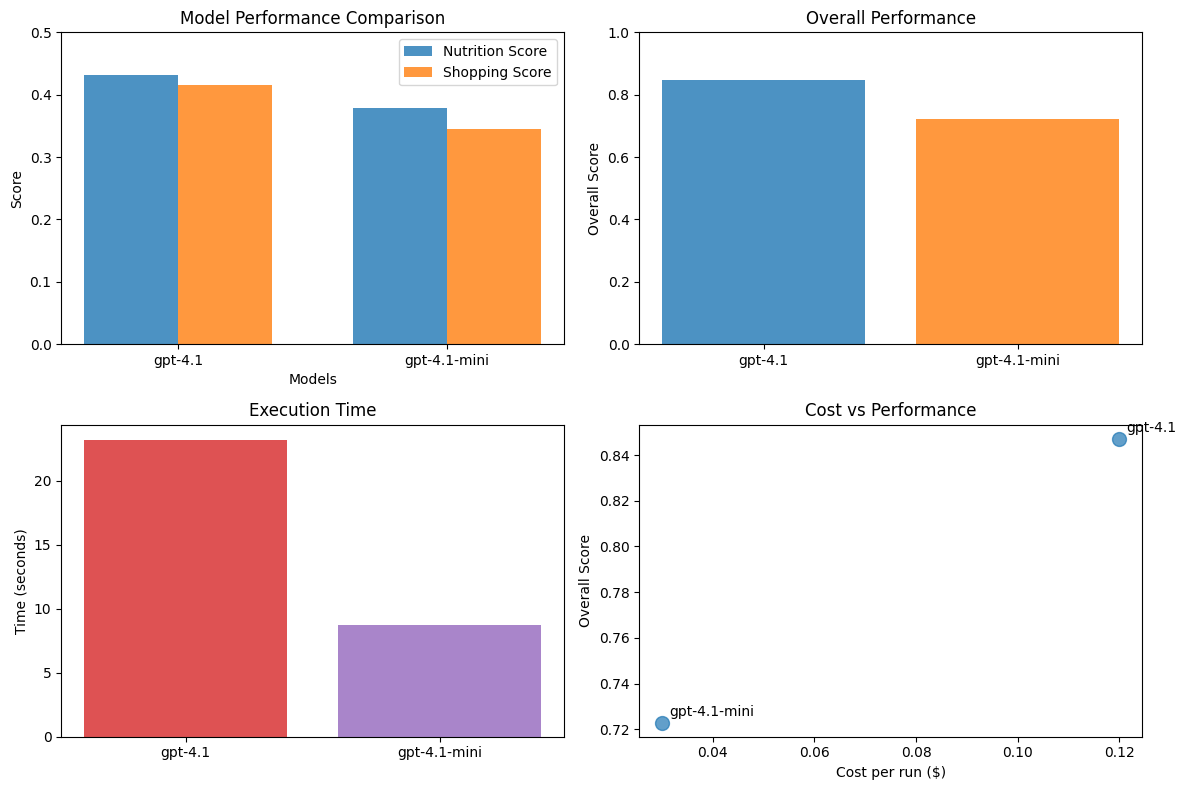

📊 Performance Summary:
  gpt-4.1:
    Overall Score: 0.847
    Execution Time: 23.2s
    Cost Efficiency: 7.1 score/$
  gpt-4.1-mini:
    Overall Score: 0.723
    Execution Time: 8.7s
    Cost Efficiency: 24.1 score/$


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Sample performance data (would come from actual evaluation runs)
models = [
    "gpt-4.1",
    "gpt-4.1-mini",
]
nutrition_scores = [
    0.432,
    0.378,
]
shopping_scores = [
    0.415,
    0.345,
]
execution_times = [
    23.2,
    8.7,
]

# Create comparison charts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Score comparison
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width / 2, nutrition_scores, width, label="Nutrition Score", alpha=0.8)
ax1.bar(x + width / 2, shopping_scores, width, label="Shopping Score", alpha=0.8)
ax1.set_xlabel("Models")
ax1.set_ylabel("Score")
ax1.set_title("Model Performance Comparison")
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim(0, 0.5)

# Overall scores
overall_scores = [
    n + s for n, s in zip(nutrition_scores, shopping_scores, strict=False)
]
ax2.bar(models, overall_scores, color=["#1f77b4", "#ff7f0e", "#2ca02c"], alpha=0.8)
ax2.set_ylabel("Overall Score")
ax2.set_title("Overall Performance")
ax2.set_ylim(0, 1.0)

# Execution time
ax3.bar(models, execution_times, color=["#d62728", "#9467bd", "#8c564b"], alpha=0.8)
ax3.set_ylabel("Time (seconds)")
ax3.set_title("Execution Time")

# Cost-performance trade-off (hypothetical data)
costs = [
    0.12,
    0.03,
]  # USD per run
ax4.scatter(costs, overall_scores, s=100, alpha=0.7)
for i, model in enumerate(models):
    ax4.annotate(
        model, (costs[i], overall_scores[i]), xytext=(5, 5), textcoords="offset points"
    )
ax4.set_xlabel("Cost per run ($)")
ax4.set_ylabel("Overall Score")
ax4.set_title("Cost vs Performance")

plt.tight_layout()
plt.show()

# Print summary
print("📊 Performance Summary:")
for i, model in enumerate(models):
    print(f"  {model}:")
    print(f"    Overall Score: {overall_scores[i]:.3f}")
    print(f"    Execution Time: {execution_times[i]}s")
    print(f"    Cost Efficiency: {overall_scores[i] / costs[i]:.1f} score/$")

## Key Learnings and Next Steps

### What Worked Well:
1. **Tool-using agent pattern**: Clean separation of concerns with FatSecret API integration
2. **Structured evaluation**: Automated scoring system enables objective model comparison
3. **Rich CLI interface**: User-friendly interaction with comprehensive output formatting
4. **Flexible architecture**: Easy to extend with new dietary constraints and evaluation metrics

### Challenges Encountered:
1. **API rate limiting**: Required careful request management and caching
2. **Nutrition data consistency**: Different food databases have varying nutritional information
3. **Response parsing**: LLM outputs needed robust validation and error handling
4. **Evaluation complexity**: Balancing multiple objectives (nutrition, cost, variety) is non-trivial

### Future Improvements:
- **Multi-agent system**: Separate agents for planning, validation, and optimization
- **Learning from feedback**: Adapt to user preferences over time
- **Recipe generation**: Create novel recipes instead of just searching existing ones
- **Seasonal awareness**: Factor in ingredient availability and seasonality
- **Batch cooking optimization**: Consider meal prep and leftover management

In [4]:
config = AgentConfig(
    model_provider=ModelProvider.OPENAI, model_name="gpt-4.1-mini", temperature=0.7
)
# Create evaluator
evaluator = NutritionEvaluator()

# Load test scenario
scenario_path = Path("../data/test_prompts/t4.json")

# Run evaluation
print("📊 Running evaluation on T4 scenario...")
evaluation_result = await evaluator.evaluate_scenario(scenario_path, config, days=3)

print("\n📈 Evaluation Results:")
print(f"Overall Score: {evaluation_result.score:.3f}/1.0")
print(f"Nutrition Score: {evaluation_result.nutrition_score:.3f}/0.5")
print(f"Shopping List Score: {evaluation_result.shopping_list_score:.3f}/0.5")
print(f"Jaccard Similarity: {evaluation_result.jaccard_similarity:.3f}")
print(f"Execution Time: {evaluation_result.execution_time:.1f}s")

if evaluation_result.violations:
    print("\n⚠️ Violations:")
    for violation in evaluation_result.violations:
        print(f"  • {violation}")

if evaluation_result.nutrition_errors:
    print("\n🔍 Nutrition Errors:")
    for macro, error in evaluation_result.nutrition_errors.items():
        print(f"  • {macro}: {error:.1f}%")

📊 Running evaluation on T4 scenario...


Using base agent to gather nutrition info and create meal plan...

Iteration 1/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "salmon_fillet"
})

• search_food_nutrition({
  "food_name": "eggs"
})

• search_food_nutrition({
  "food_name": "spinach"
})

• search_food_nutrition({
  "food_name": "sweet_potato"
})

• search_food_nutrition({
  "food_name": "greek_yogurt"
})

• search_food_nutrition({
  "food_name": "whole_grain_bread"
})

• search_food_nutrition({
  "food_name": "almond_butter"
})

• search_food_nutrition({
  "food_name": "lentils_canned"
})

• search_food_nutrition({
  "food_name": "avocado"
})

• search_food_nutrition({
  "food_name": "pasteurised_milk"
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_DaM │ ✓ Success │ {'foods': [{'name': 'Salmon Fillet', 'brand': 'Safeway', 'nutrition_per_100g':           │
│          │           │ {'calories': 5666.666...                                                                 │
│ call_4Dk │ ✓ Success │ {'foods': [{'name': 'Egg', 'brand': None, 'nutrition_per_100g': {'calories': 147.0,      │
│          │           │ 'protein_g': 12....                                                                      │
│ call_4Ls │ ✓ Success │ {'foods': [{'name': 'Spinach', 'brand': None, 'nutrition_per_100g': {'calories': 23.0,   │
│          │           │ 'protein_g': ...                                                                         │
│ call_7ce │ ✓ Success │ {'foods': [{'name': 'Sweet Potato', 'brand': "Nature's Pride", 'nutrition_per_100g':     │
│          │           │ {'calories': 82...                                                                       │
│ call_Sjr │ ✓ Success │ {'foods': [{'name': 'Greek Yogurt', 'brand': 'Kirkland Signature', 'nutrition_per_100g': │
│          │           │ {'calories'...                                                                           │
│ call_CHG │ ✓ Success │ {'foods': [{'name': 'Whole Grain Bread', 'brand': None, 'nutrition_per_100g':            │
│          │           │ {'calories': 251.0, 'p...                                                                │
│ call_sEi │ ✓ Success │ {'foods': [{'name': 'Almond Butter', 'brand': "Nuts 'N More", 'nutrition_per_100g':      │
│          │           │ {'calories': 603...                                                                      │
│ call_wy7 │ ✓ Success │ {'foods': []}...                                                                         │
│ call_aQJ │ ✓ Success │ {'foods': [{'name': 'Avocado', 'brand': 'Calavo', 'nutrition_per_100g': {'calories':     │
│          │           │ 173.33333333333...                                                                       │
│ call_xsy │ ✓ Success │ {'foods': []}...                                                                         │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 2/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_recipes_by_ingredients({
  "ingredients": [
    "salmon_fillet",
    "eggs",
    "spinach",
    "sweet_potato",
    "greek_yogurt",
    "whole_grain_bread",
    "almond_butter",
    "lentils_canned",
    "avocado",
    "pasteurised_milk"
  ],
  "dietary_restrictions": [
    "pregnancy",
    "no_raw_fish",
    "no_high_mercury_fish",
    "no_unpasteurised_cheese",
    "no_alcohol"
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_mPe │ ✓ Success │ {'recipes': [{'name': 'Spinach Eggs', 'description': "An egg substitute scramble for     │
│          │           │ breakfast that'...                                                                       │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 3/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_food_nutrition({
  "food_name": "ham"
})

• search_food_nutrition({
  "food_name": "olive oil"
})

• search_food_nutrition({
  "food_name": "mushrooms"
})

• search_food_nutrition({
  "food_name": "onion"
})

• search_food_nutrition({
  "food_name": "garlic"
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_lMe │ ✓ Success │ {'foods': [{'name': 'Sliced Ham  (Regular, Approx. 11% Fat)', 'brand': None,             │
│          │           │ 'nutrition_per_100g': {...                                                               │
│ call_2ur │ ✓ Success │ {'foods': [{'name': 'Olive Oil', 'brand': None, 'nutrition_per_100g': {'calories':       │
│          │           │ 884.0, 'protein_g...                                                                     │
│ call_zEv │ ✓ Success │ {'foods': [{'name': 'Mushrooms', 'brand': None, 'nutrition_per_100g': {'calories': 22.0, │
│          │           │ 'protein_g'...                                                                           │
│ call_iWT │ ✓ Success │ {'foods': [{'name': 'Onions', 'brand': None, 'nutrition_per_100g': {'calories': 42.0,    │
│          │           │ 'protein_g': 0...                                                                        │
│ call_r66 │ ✓ Success │ {'foods': [{'name': 'Garlic', 'brand': None, 'nutrition_per_100g': {'calories': 149.0,   │
│          │           │ 'protein_g': ...                                                                         │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 4/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• calculate_pfc_balance({
  "meals": [
    {
      "name": "Spinach Scrambled Eggs",
      "calories": 331,
      "protein_g": 25.44,
      "fat_g": 18.71,
      "carbs_g": 15.14
    },
    {
      "name": "Sweet Potato and Lentil Salad",
      "calories": 400,
      "protein_g": 20,
      "fat_g": 10,
      "carbs_g": 50
    },
    {
      "name": "Salmon with Spinach and Sweet Potato",
      "calories": 600,
      "protein_g": 40,
      "fat_g": 30,
      "carbs_g": 40
    }
  ],
  "target_calories": 2200,
  "target_pfc": [
    25,
    30,
    45
  ]
})

                                                   Tool Results                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status    ┃ Output                                                                                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_YUC │ ✓ Success │ {'daily_totals': {'calories': 1331, 'protein_g': 85.44, 'fat_g': 58.71, 'carbs_g':       │
│          │           │ 105.14, 'pfc_rati...                                                                     │
└──────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

Iteration 5/10

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔧 Executing Tools                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

• search_recipes_by_ingredients({
  "ingredients": [
    "salmon_fillet",
    "eggs",
    "spinach",
    "sweet_potato",
    "greek_yogurt",
    "whole_grain_bread",
    "almond_butter",
    "lentils_canned",
    "avocado",
    "pasteurised_milk"
  ],
  "dietary_restrictions": [
    "pregnancy",
    "no_raw_fish",
    "no_high_mercury_fish",
    "no_unpasteurised_cheese",
    "no_alcohol"
  ],
  " }": true
})

                                          Tool Results                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool     ┃ Status  ┃ Output                                                                  ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ call_QN0 │ ✗ Error │ search_recipes_by_ingredients() got an unexpected keyword argument ' }' │
└──────────┴─────────┴─────────────────────────────────────────────────────────────────────────┘

Iteration 6/10

╭─────────────────────────────────────────────── 🤖 Agent Response ───────────────────────────────────────────────╮
│ I have obtained nutritional information for all key ingredients and found some recipes using the available      │
│ ingredients. Initial meal plan calculations show the nutritional targets are not fully met, especially          │
│ calories, protein, fat, and carbs are off by significant margins. I will now create a balanced 3-day meal plan  │
│ using the available ingredients, adjusting portion sizes and combining recipes to meet daily nutritional        │
│ targets of 2200 kcal with 25% protein, 30% fat, and 45% carbohydrates, while adhering to pregnancy and dietary  │
│ restrictions.                                                                                                   │
│                                                                                                                 │
│ Here is the detailed 3-day meal plan:                                                                           │
│                                                                                                                 │
│ {                                                                                                               │
│   "meal_plans": [                                                                                               │
│     {                                                                                                           │
│       "day": 1,                                                                                                 │
│       "breakfast": {                                                                                            │
│         "name": "Spinach Scrambled Eggs with Whole Grain Toast",                                                │
│         "ingredients": [                                                                                        │
│           "2 large eggs (100g approx)",                                                                         │
│           "1 cup spinach (100g)",                                                                               │
│           "1/2 tbsp olive oil (7g)",                                                                            │
│           "2 slices whole grain bread (60g)"                                                                    │
│         ],                                                                                                      │
│         "calories": 420,                                                                                        │
│         "protein_g": 28,                                                                                        │
│         "fat_g": 22,                                                                                            │
│         "carbs_g": 30,                                                                                          │
│         "cooking_instructions": "Heat olive oil in a pan, sauté spinach until wilted. Beat eggs and add to pan, │
│ scramble with spinach until cooked. Toast whole grain bread and serve alongside."                               │
│       },                                                                                                        │
│       "lunch": {                                                                                                │
│         "name": "Salmon Fillet with Sweet Potato and Steamed Spinach",                                          │
│         "ingredients": [                                                                                        │
│           "150g salmon fillet",                                                                                 │
│           "200g sweet potato",                                                                                  │
│           "100g spinach",                              


📈 Evaluation Results:
Overall Score: 0.000/1.0
Nutrition Score: 0.000/0.5
Shopping List Score: 0.000/0.5
Jaccard Similarity: 0.000
Execution Time: 96.7s

⚠️ Violations:
  • Calories off by 23.2%
  • Protein off by 15.6%
  • Fat off by 10.0%
  • Carbs off by 51.5%

🔍 Nutrition Errors:
  • calories: 23.2%
  • protein: 15.6%
  • fat: 10.0%
  • carbs: 51.5%
